# Importing Libraries

In [1]:
import numpy as np 
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import pydot
import random
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, BatchNormalization, Conv2DTranspose, Concatenate, Reshape, LeakyReLU, Input, UpSampling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.datasets import mnist
from tensorflow.compat.v1 import ConfigProto, InteractiveSession

# GPU Configuration

In [2]:
config=ConfigProto()
config.gpu_options.allow_growth=True
sess=InteractiveSession(config=config)

# Dataset

## Loading

In [3]:
(x_train, y_train), (x_test, y_test)=mnist.load_data()

## Preprocessing

In [4]:
x_train=x_train.reshape((-1,28,28,1))/255.0
x_test=x_test.reshape((-1,28,28,1))/255.0
ohe=OneHotEncoder(sparse=False)
y_train=ohe.fit_transform(y_train.reshape((-1,1)))
y_test=ohe.transform(y_test.reshape((-1,1)))

## Analysis

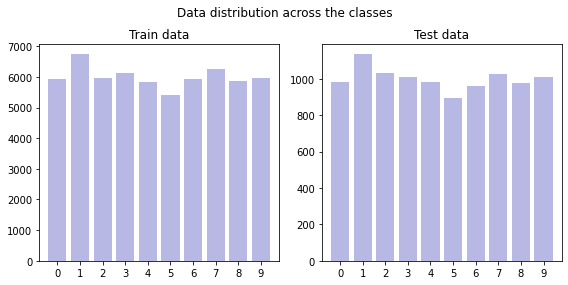

In [5]:
n1=np.sum(y_test,axis=0)
n2=np.sum(y_train, axis=0)
c=np.arange(0,n1.shape[0])
fig=plt.figure(figsize=(8,4))
ax1=fig.add_subplot(122)
ax1.bar(c,n1,color="#b8b8e5")
ax1.set_xticks(c)
ax1.set_xlim((-0.8,n1.shape[0]-0.2))
ax1.set_title("Test data")
ax2=fig.add_subplot(121)
ax2.bar(c,n2,color="#b8b8e5")
ax2.set_xticks(c)
ax2.set_xlim((-0.8,n2.shape[0]-0.2))
ax2.set_title("Train data")
plt.tight_layout()
fig.suptitle("Data distribution across the classes")
fig.subplots_adjust(top=0.85)
plt.savefig('resources/data_analysis.png',dpi=300)
plt.show()

## Visualization

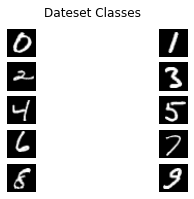

In [6]:
fig=plt.figure(figsize=(5,3))
for i in range(10):
    ax=fig.add_subplot(5,2,i+1)
    ax.axis('off')
    temp=random.randint(0,x_train[y_train[:,i]==1].shape[0]-1)
    ax.imshow(np.uint8(255*(x_train[y_train[:,i]==1][temp].reshape((28,28)))),cmap='gray')
fig.suptitle("Dateset Classes")
plt.savefig("resources/dataclass.png",dpi=300)
plt.show()

# Model Definition

## Generator

In [7]:
def gen(latent):
    in1=Input(shape=(latent))
    x1=Dense(7*7*128)(in1)
    x1=LeakyReLU(alpha=0.2)(x1)
    x1=Reshape((7,7,128))(x1)

    in2=Input(shape=(10))
    x2=Dense(49)(in2)
    x2=LeakyReLU(alpha=0.2)(x2)
    x2=Reshape((7,7,1))(x2)

    x=Concatenate()([x1,x2])

    x=UpSampling2D()(x)
    x=Conv2DTranspose(128, (3,3), padding='same')(x)
    x=LeakyReLU(alpha=0.2)(x)

    x=UpSampling2D()(x)
    x=Conv2DTranspose(128, (3,3), padding='same')(x)
    x=LeakyReLU(alpha=0.2)(x)

    x=Conv2DTranspose(1, (3,3), padding='same', activation='sigmoid')(x)

    return Model([in1, in2], x)

## Discriminator

In [8]:
def disc():
    in1=Input(shape=(28,28,1))

    in2=Input(shape=(10))
    x2=Dense(28*28)(in2)
    x2=LeakyReLU(alpha=0.2)(x2)
    x2=Reshape((28,28,1))(x2)

    x=Concatenate()([in1,x2])

    x=Conv2D(64, 3, padding='same')(x)
    x=MaxPool2D()(x)
    x=LeakyReLU(alpha=0.2)(x)

    x=Conv2D(128, 3, padding='same')(x)
    x=MaxPool2D()(x)
    x=LeakyReLU(alpha=0.2)(x)

    x=Flatten()(x)
    x=Dense(1, activation='sigmoid')(x)
    
    return Model([in1, in2], x)

## Adversarial

In [9]:
def models(latent):
    d=disc()
    g=gen(latent)
    
    d.compile(optimizer=Adam(learning_rate=0.00002, beta_1=0.5), loss='binary_crossentropy', metrics=['accuracy'])

    d.trainable=False
    adv=Model(g.input, d([g.output,g.input[1]]))

    adv.compile(optimizer=Adam(learning_rate=0.0001, beta_1=0.5), loss='binary_crossentropy')

    return g, d, adv

# Training loop definition

In [10]:
def train(latent, epochs, batch_size, x, y, ohe, shuffle, save_interval, image_gen):
    assert x.shape[0]==y.shape[0], "x.shape[0]!=y.shape[0]"
    assert batch_size>1, "Batch size should be more than 1" 
    g, d, a=models(latent)
    
    plot_model(g,to_file="resources/generator.png", show_shapes=True, show_layer_names=True, rankdir="TB")
    plot_model(d,to_file="resources/discriminator.png", show_shapes=True, show_layer_names=True, rankdir="TB")
    plot_model(a,to_file="resources/adversarial.png", show_shapes=True, show_layer_names=True, rankdir="TB")
    
    n=y.shape[0]
    l=np.arange(0,n)
    hist={
        "discriminator_loss":list(),
        "discriminator_accuracy":list(),
        "adversarial_loss":list(),
    }
    for i in range(epochs):
        if shuffle:
            np.random.shuffle(l)
        tld=list()
        tad=list()
        tla=list()
        for j in range(0, n-batch_size+1, batch_size):
            f=j+batch_size
            if f>=n:
                f=n
            
            latentnoise=np.random.random((batch_size//2, latent))
            randlabel=np.random.randint(10, size=batch_size//2).reshape((-1,1))
            randlabel=ohe.transform(randlabel)
            
            fpred=g.predict([latentnoise, randlabel])

            dlossf, daccf=d.train_on_batch([fpred, randlabel], np.zeros(batch_size//2))

            realx=x[l[j:f-batch_size//2],:,:,:]
            realy=y[l[j:f-batch_size//2],:]
            latentnoise=np.random.random((batch_size//2, latent))

            dlossr, daccr=d.train_on_batch([realx, realy], np.ones(batch_size//2))

            dloss=0.5*(dlossf+dlossr)
            dacc=0.5*(daccf+daccr)

            latentnoise=np.random.random((batch_size, latent))
            randlabel=np.random.randint(10, size=batch_size).reshape((-1,1))
            randlabel=ohe.transform(randlabel)
            aloss=a.train_on_batch([latentnoise, randlabel], np.ones(batch_size))

            tld.append(dloss)
            tla.append(aloss)
            tad.append(dacc)
            bar="="*((j*19)//n)+">"+"-"*(19-((j*19)//n))
            print("Epoch %d/%d [%s]: d_loss:%f d_acc:%f a_loss:%f"%(i+1,epochs,bar,dloss,dacc,aloss), end='\r')
        print("Epoch %d/%d: d_loss:%f d_acc:%f a_loss:%f"%(i+1,epochs,dloss,dacc,aloss))
        hist["discriminator_loss"].append(tld)
        hist["discriminator_accuracy"].append(tad)
        hist["adversarial_loss"].append(tla)
        if (i+1)%save_interval==0:
            g.save("models/gen%d.h5"%i)
            a.save("models/adv%d.h5"%i)
            d.save("models/dis%d.h5"%i)
        if (i+1)%image_gen==0:
            fig=plt.figure()
            latentnoise=np.random.random((10, latent))
            lab=np.arange(10).reshape((-1,1))
            lab=ohe.transform(lab)
            im=g.predict([latentnoise, lab])
            for q in range(10):
                ax=fig.add_subplot(5, 2, q+1)
                ax.imshow(im[q].reshape((28,28)), cmap='gray')
                ax.axis('off')
            plt.savefig('images/%d.jpg'%(i+1))
    return hist, g, d, a

# Training

Epoch 1/15: d_loss:0.622574 d_acc:0.968750 a_loss:0.710216
Epoch 2/15: d_loss:0.738362 d_acc:0.031250 a_loss:0.660177
Epoch 3/15: d_loss:0.675623 d_acc:0.718750 a_loss:0.728438
Epoch 4/15: d_loss:0.603680 d_acc:1.000000 a_loss:0.740525
Epoch 5/15: d_loss:0.622181 d_acc:0.968750 a_loss:0.764979
Epoch 6/15: d_loss:0.659913 d_acc:0.750000 a_loss:0.755104
Epoch 7/15: d_loss:0.689370 d_acc:0.437500 a_loss:0.681840
Epoch 8/15: d_loss:0.698099 d_acc:0.500000 a_loss:0.680793
Epoch 9/15: d_loss:0.679293 d_acc:0.593750 a_loss:0.697408
Epoch 10/15: d_loss:0.706690 d_acc:0.468750 a_loss:0.702738
Epoch 11/15: d_loss:0.695266 d_acc:0.468750 a_loss:0.665375
Epoch 12/15: d_loss:0.681973 d_acc:0.687500 a_loss:0.693535
Epoch 13/15: d_loss:0.692797 d_acc:0.437500 a_loss:0.697354
Epoch 14/15: d_loss:0.711281 d_acc:0.281250 a_loss:0.676222
Epoch 15/15: d_loss:0.692964 d_acc:0.531250 a_loss:0.689461


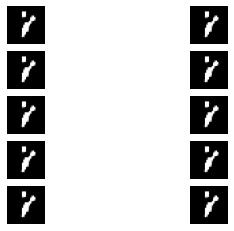

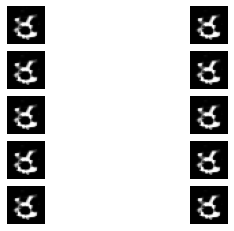

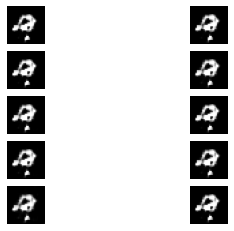

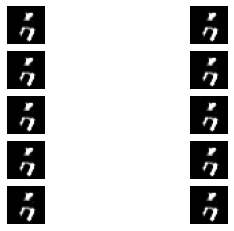

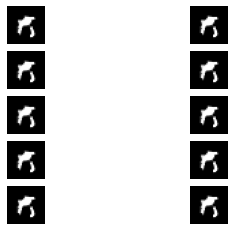

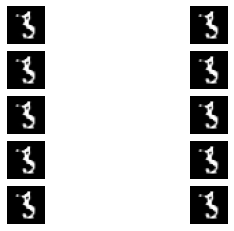

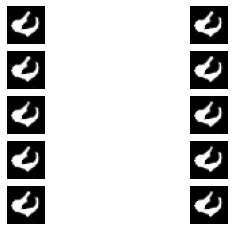

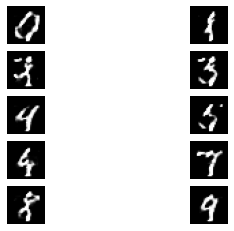

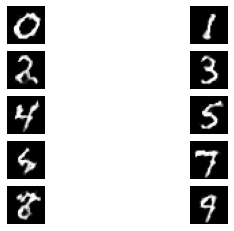

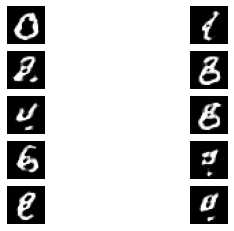

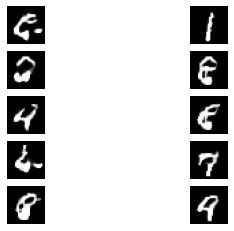

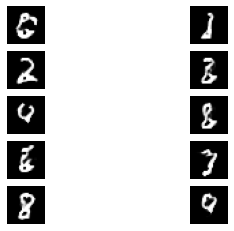

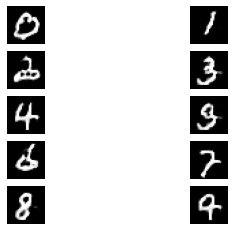

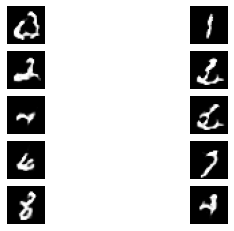

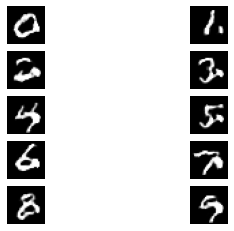

In [11]:
h,_,_,_=train(100, 15, 32, x_train, y_train, ohe, True, 1, 1)

# Visual representation of the Models

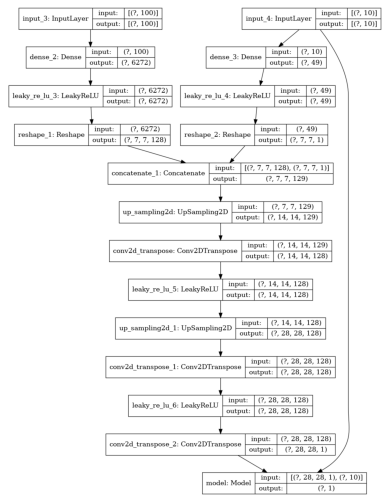

In [12]:
fig=plt.figure(figsize=(9,9))
img=plt.imread("resources/adversarial.png")
plt.imshow(img)
plt.axis('off')
plt.show()

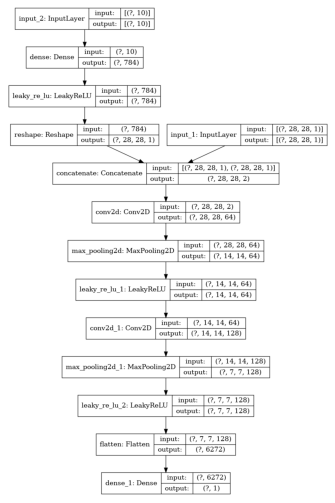

In [13]:
fig=plt.figure(figsize=(9,9))
img=plt.imread("resources/discriminator.png")
plt.imshow(img)
plt.axis('off')
plt.show()

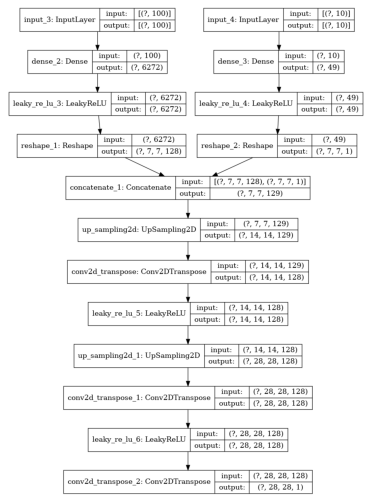

In [14]:
fig=plt.figure(figsize=(9,9))
img=plt.imread("resources/generator.png")
plt.imshow(img)
plt.axis('off')
plt.show()

# Model Perfomance Visualization

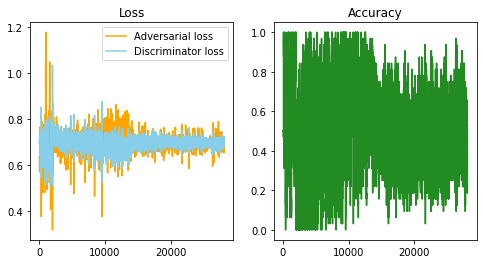

In [15]:
fig=plt.figure(figsize=(8,4))
ax1=fig.add_subplot(121)
ax1.plot(np.array(h["adversarial_loss"]).reshape((-1)), color='#ffa500', label="Adversarial loss")
ax1.plot(np.array(h["discriminator_loss"]).reshape((-1)), color='#87ceeb', label="Discriminator loss")
ax1.set_title("Loss")
ax1.legend()
ax2=fig.add_subplot(122)
ax2.plot(np.array(h["discriminator_accuracy"]).reshape((-1)), color='#228b22', label="Discriminator accuracy")
ax2.set_title("Accuracy")
fig.savefig("resources/performance.png",dpi=300)

# Best Generation

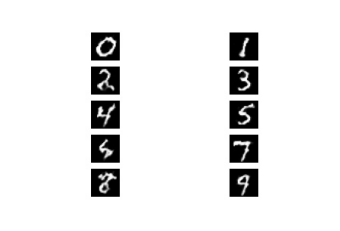

In [22]:
img=plt.imread("images/9.jpg",0)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()